# Histogram and Histogram Equalization

This notebook follows the HW requirements: code + outputs + short explanations.  

The required libraries are imported, and a single IMAGE_PATH variable is defined to ensure the notebook is easy to run.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Configuration
IMAGE_PATH = "img.jpg"


def show(img, title=None, cmap=None, figsize=(6, 4)):
    """Consistent image display."""
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.axis("off")
    plt.show()


def plot_hist(hist, title, figsize=(8, 4)):
    """Plot a 256-bin histogram."""
    x = np.arange(256)
    plt.figure(figsize=figsize)
    plt.bar(x, hist, width=1.0)
    plt.xlim([0, 255])
    plt.xlabel("Pixel Intensity (0–255)")
    plt.ylabel("Number of Pixels")
    plt.title(title)
    plt.show()


## 1. Compute the Histogram of a Grayscale Image

**Goal:** Read an image, convert to grayscale, and compute its histogram **manually** using NumPy.  
We also compare with OpenCV (`cv2.calcHist`) for validation.

Grayscale shape: (360, 640)
Grayscale dtype: uint8


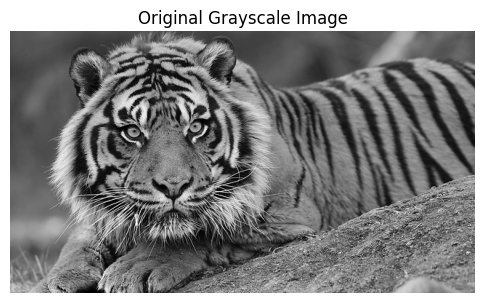

In [ ]:
# Read image (BGR) and convert to grayscale
img_bgr = cv2.imread(IMAGE_PATH)
assert img_bgr is not None, f"Failed to load image from: {IMAGE_PATH}"

gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

print("Grayscale shape:", gray.shape)
print("Grayscale dtype:", gray.dtype)
show(gray, title="Original Grayscale Image", cmap="gray")


In [ ]:
# Manual histogram (0..255): hist[i] = number of pixels with intensity i
hist_manual = np.bincount(gray.ravel(), minlength=256).astype(np.int64)

# Sanity check: sum(hist) must equal number of pixels
print("Total pixels:", gray.size)
print("Sum of hist_manual:", int(hist_manual.sum()))

# Optional comparison with OpenCV
hist_cv = cv2.calcHist([gray], [0], None, [256], [0, 256]).ravel()
print("First 10 bins (manual):", hist_manual[:10])
print("First 10 bins (OpenCV):", hist_cv[:10])


Total pixels: 230400
Sum of hist_manual: 230400
First 10 bins (manual): [800 466 168 184 155 180 181 192 198 251]
First 10 bins (OpenCV): [800. 466. 168. 184. 155. 180. 181. 192. 198. 251.]


## 2. Plot the Histogram

We plot the histogram with:
- x-axis: intensity values (0–255)
- y-axis: number of pixels

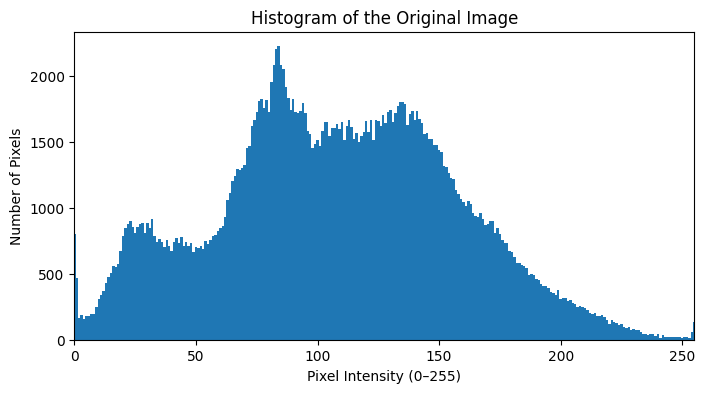

In [ ]:
plot_hist(hist_manual, title="Histogram of the Original Image")

## 3. Interpretation Questions

**a. What does it mean when the histogram is concentrated on the left side?**  
Most pixels are dark (low intensities), so the image tends to look underexposed.

**b. What does it mean when the histogram is stretched across all values?**  
Pixel intensities cover a wide range, usually indicating higher contrast (both dark and bright regions exist).

**c. What do high peaks represent?**  
A high peak at intensity *i* means many pixels share that same intensity value (common in large flat regions).


## 4. Histogram Equalization

We apply histogram equalization using **two** approaches:
1. **Manual (CDF method)** — to demonstrate understanding.
2. **OpenCV** (`cv2.equalizeHist`) — for comparison.

Then we display:
- Original image + histogram
- Equalized image + histogram


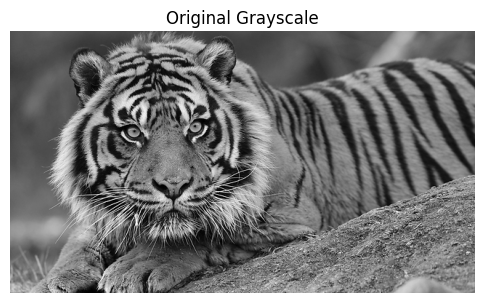

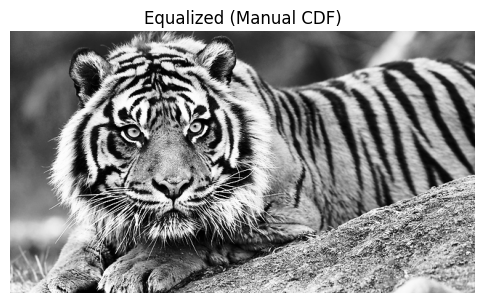

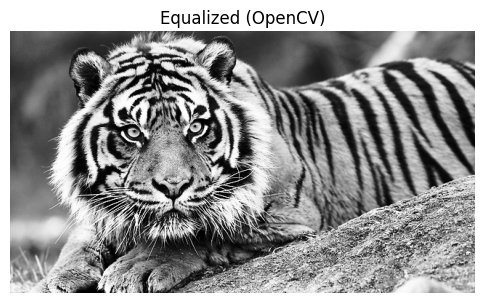

MAE between manual and OpenCV equalization: 0.5477777777777778


In [ ]:
def equalize_hist_manual(gray_img: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Manual histogram equalization using the CDF method (uint8 grayscale).

    Returns:
        eq_img: equalized image
        hist: original histogram (256,)
        hist_eq: equalized histogram (256,)
    """
    assert gray_img.dtype == np.uint8, "Expected uint8 grayscale input"

    hist = np.bincount(gray_img.ravel(), minlength=256).astype(np.float64)
    cdf = np.cumsum(hist)

    # Avoid division by zero: find first non-zero CDF value
    cdf_min = cdf[cdf > 0].min() if np.any(cdf > 0) else 0.0
    n = gray_img.size

    # Build LUT (mapping 0..255 -> 0..255)
    if n == cdf_min:
        # Degenerate case: all pixels have the same value
        lut = np.arange(256, dtype=np.uint8)
    else:
        lut = np.floor((cdf - cdf_min) / (n - cdf_min) * 255.0)
        lut = np.clip(lut, 0, 255).astype(np.uint8)

    eq_img = lut[gray_img]
    hist_eq = np.bincount(eq_img.ravel(), minlength=256).astype(np.float64)
    return eq_img, hist.astype(np.int64), hist_eq.astype(np.int64)


equalized_manual, hist_original, hist_equalized_manual = equalize_hist_manual(gray)

# OpenCV equalization for comparison
equalized_cv = cv2.equalizeHist(gray)
hist_equalized_cv = np.bincount(equalized_cv.ravel(), minlength=256).astype(np.int64)

# Show images
show(gray, title="Original Grayscale", cmap="gray")
show(equalized_manual, title="Equalized (Manual CDF)", cmap="gray")
show(equalized_cv, title="Equalized (OpenCV)", cmap="gray")

# Numeric comparison (optional)
mae = np.mean(np.abs(equalized_manual.astype(np.int16) - equalized_cv.astype(np.int16)))
print("MAE between manual and OpenCV equalization:", float(mae))


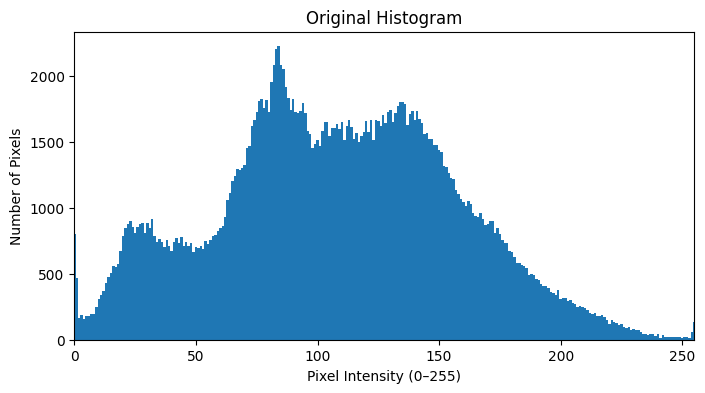

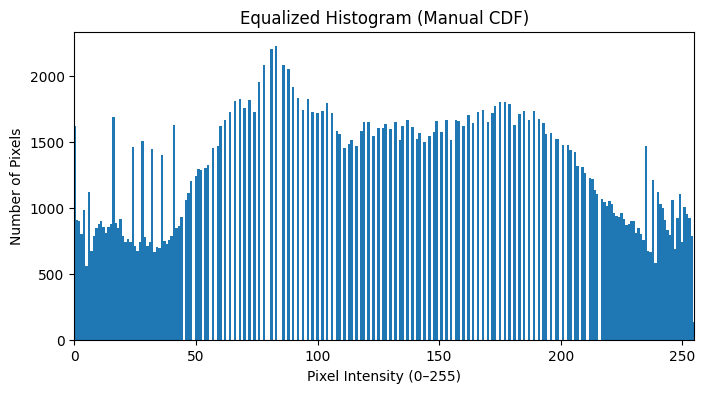

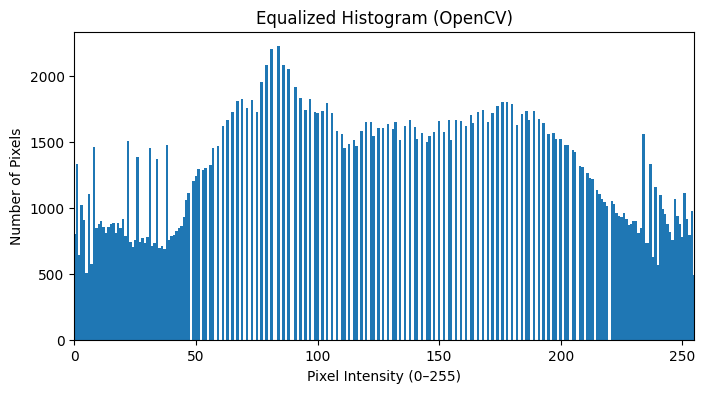

In [ ]:
# Plot histograms: original and equalized (manual)
plot_hist(hist_original, title="Original Histogram")
plot_hist(hist_equalized_manual, title="Equalized Histogram (Manual CDF)")
plot_hist(hist_equalized_cv, title="Equalized Histogram (OpenCV)")

### 4d. How does histogram equalization change the distribution of pixel intensities?

Histogram equalization remaps intensities using the cumulative distribution function (CDF).  
This tends to **spread** frequent intensity values across a wider range, increasing global contrast—especially when the original histogram is compressed into a narrow region.


## 5. Comparison

**i. When does histogram equalization improve images?**  
When the image has low contrast (histogram concentrated in a narrow range), e.g., low-light or hazy scenes.

**ii. When does it create noise or distort colors?**  
It can amplify noise in dark regions. On color images, equalizing each RGB channel separately can distort colors (a common approach is to equalize only the luminance channel).

**iii. Why is it often used on medical or low-light images?**  
Because these images frequently have a compressed intensity range; equalization helps reveal subtle structures by increasing contrast.
